In [1]:
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import pandas as pd
import re
import statsmodels.api as sm
import statsmodels.graphics as g
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.ticker as mtick
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style()

# Hide Code in Slideshow

In [2]:
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

# MVP

## Read In

In [3]:
states = pd.read_csv('../data/state_reps_ref.csv')
states = states.rename(columns = {'abbreviation': 'code'})
states

,state,code,representatives
0,Alabama,AL,7
1,Alaska,AK,1
2,Arizona,AZ,9
3,Arkansas,AR,4
4,California,CA,53
5,Colorado,CO,7
6,Connecticut,CT,5
7,Delaware,DE,1
8,Florida,FL,27
9,Georgia,GA,14


In [4]:
# Read in campaign-funds data from Problem 3
US = pd.read_csv('../data/us_rep_elections.csv')
US

,district,name,party,incumbent,winner,raised,spent,state
0,AL01,Jerry Carl,R,False,True,1971321,1859349,Alabama
1,AL01,James Averhart,D,False,False,80095,78973,Alabama
2,AL02,Barry Moore,R,False,True,650807,669368,Alabama
3,AL02,Phyllis Harvey-Hall,D,False,False,56050,55988,Alabama
4,AL03,Mike D Rogers,R,True,True,1193111,1218564,Alabama
...,...,...,...,...,...,...,...,...
889,WI07,Tricia Zunker,D,False,False,1261957,1232690,Wisconsin
890,WI08,Mike Gallagher,R,True,True,3202905,2841801,Wisconsin
891,WI08,Amanda Stuck,D,False,False,416978,399916,Wisconsin
892,WY01,Liz Cheney,R,True,True,3003883,3060167,Wyoming


In [5]:
# Read in source-of-funds data from Bonus
SOF = pd.read_csv('../data/us_rep_source_of_funds.csv')
SOF

,state,district,name,party,incumbent,winner,type of contribution,amount,percentage
0,Alabama,AL01,Jerry Carl,R,False,True,Small Individual Contributions (≤ $200),44580,0.0226
1,Alabama,AL01,Jerry Carl,R,False,True,Large Individual Contributions,999616,0.5071
2,Alabama,AL01,Jerry Carl,R,False,True,PAC Contributions*,387000,0.1963
3,Alabama,AL01,Jerry Carl,R,False,True,Candidate self-financing,434656,0.2205
4,Alabama,AL01,Jerry Carl,R,False,True,Other,105470,0.0535
...,...,...,...,...,...,...,...,...,...
4465,Wyoming,WY01,Lynnette Grey Bull,D,False,False,Small Individual Contributions (≤ $200),64222,0.4771
4466,Wyoming,WY01,Lynnette Grey Bull,D,False,False,Large Individual Contributions,65975,0.4902
4467,Wyoming,WY01,Lynnette Grey Bull,D,False,False,PAC Contributions*,2800,0.0208
4468,Wyoming,WY01,Lynnette Grey Bull,D,False,False,Candidate self-financing,0,0.0000


## How often does the candidate who raised more money win a race? 

In [6]:
# Function for comparing money column (either spent or raised) to election wins.

def money_wins(money_col):
    US['more'] = US[money_col] == US.groupby('district')[money_col].transform('max')

    moneywins = US.groupby('more')['winner'].agg(['sum', 'mean']).reset_index(drop = False)
    display(moneywins)

    fig, ax = plt.subplots(figsize = (10,6))

    sns.barplot(x = 'more',
                y = 'sum',
                data = moneywins,
               )

    ax.set(xlabel = f"Candidate {money_col.capitalize()} Most",
           ylabel = "Count",
           title = f"Frequency of Most {money_col.capitalize()} Winning"
           )

    def show_values_on_bars(axs):
        def _show_on_single_plot(ax):        
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = '{}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

    show_values_on_bars(ax)

,more,sum,mean
0,False,47,0.102397
1,True,384,0.882759


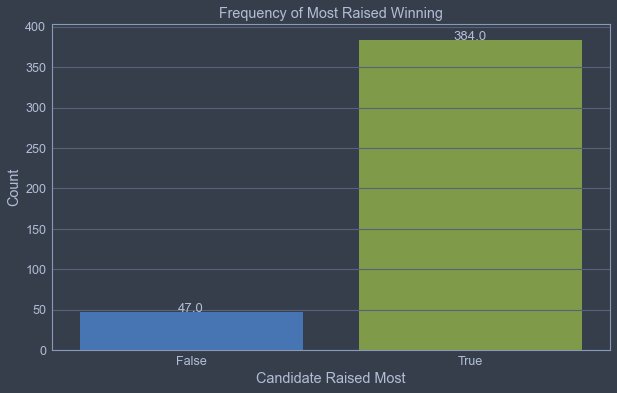

In [7]:
money_wins('raised')

Candidates who raised the most money win their elections 88% of the time based on the data from the 2020 House of Representatives elections.

## How often does the candidate who spent more money win a race? 

,more,sum,mean
0,False,47,0.102397
1,True,384,0.882759


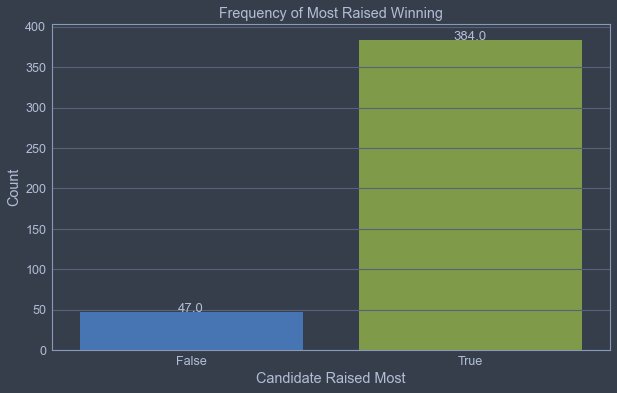

In [8]:
money_wins('raised')

Candidates who spent the most money also win their elections 88% of the time based on the data from the 2020 House of Representatives elections.

## Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

In [9]:
# Build a Logistic regression model with target variable equal to if a candidate won the race or not, 
# predictor variable will be money raised
raised_model = (sm.GLM(endog = US['winner'],
                       exog = sm.add_constant(US[['raised']]),
                       family = sm.families.Binomial())
                .fit())

print(raised_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 winner   No. Observations:                  894
Model:                            GLM   Df Residuals:                      892
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.13
Date:                Fri, 22 Oct 2021   Deviance:                       1134.3
Time:                        22:04:20   Pearson chi2:                 1.03e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6842      0.096     -7.147      0.0

In [10]:
# Build a Logistic regression model with target variable equal to if a candidate won the race or not, 
# predictor variable will be money spent
spent_model = (sm.GLM(endog = US['winner'],
                      exog = sm.add_constant(US[['spent']]),
                      family = sm.families.Binomial())
               .fit())

print(spent_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 winner   No. Observations:                  894
Model:                            GLM   Df Residuals:                      892
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -581.62
Date:                Fri, 22 Oct 2021   Deviance:                       1163.2
Time:                        22:04:20   Pearson chi2:                     955.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5552      0.091     -6.076      0.0

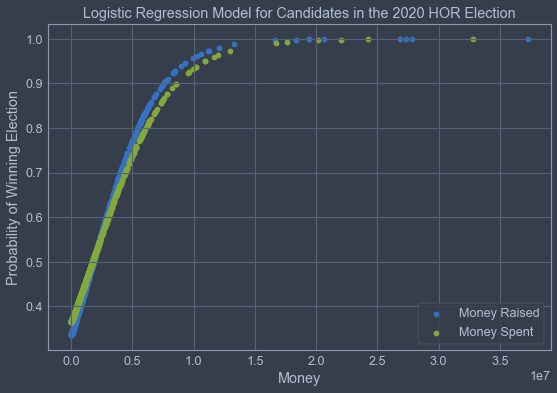

In [11]:
# Plot Logistic regression model results from previous cells
plt.subplots(figsize=(9,6))

x_raised = US['raised']
y_raised = 1 / (1 + (np.exp(-raised_model.params[0] - (raised_model.params[1]*x_raised))))
plt.scatter(x_raised, y_raised)

x_spent = US['spent']
y_spent = 1 / (1 + (np.exp(-spent_model.params[0] - (spent_model.params[1]*x_spent))))
plt.scatter(x_spent, y_spent)

plt.xlabel("Money")
plt.ylabel("Probability of Winning Election")
plt.title("Logistic Regression Model for Candidates in the 2020 HOR Election")
plt.legend(['Money Raised', 'Money Spent']);

Our models show us that as candidates raise and spend more money the probability of the candidate winning the race increases. From our results, it would seem that money raised and money spent are equally useful in predicting if a candidate will win their election or not.

## How often does the incumbent candidate win a race?

In [12]:
# Group dataset by Incumbent status and if if they won the race or not
incumbent_winners = US.groupby(['incumbent', 'winner']).size().unstack().iloc[::-1, ::-1]
incumbent_winners.iloc[0] = incumbent_winners.iloc[0]/incumbent_winners.iloc[0].sum()
incumbent_winners.iloc[1] = incumbent_winners.iloc[1]/incumbent_winners.iloc[1].sum()
display(incumbent_winners)

winner,True,False
incumbent,,
True,0.96114,0.03886
False,0.11811,0.88189


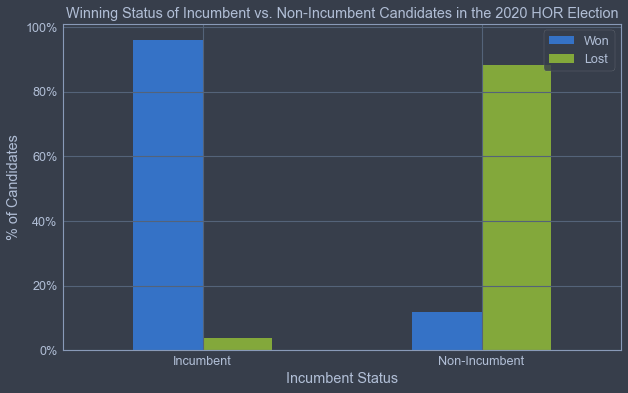

In [13]:
# Investigate how often the incumbent candidate wins a race
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
incumbent_winners.plot(kind='bar',
                       rot=0,
                       ax=ax)
plt.title('Winning Status of Incumbent vs. Non-Incumbent Candidates in the 2020 HOR Election')
plt.xlabel('Incumbent Status')
plt.ylabel('% of Candidates')
plt.xticks([0,1], ['Incumbent', 'Non-Incumbent'])
plt.legend(['Won', 'Lost'], loc=1);

Based on the 2020 House of Representative election data, incumbent candidates are highly likely to be re-elected. 96% of incumbent candidates from the 2020 House of Representatives elections were re-elected.

On the other hand, it is very unlikely for a non-incumbent candidate to win their race. Only 12% of non-incumbent candidates from the 2020 House of Representatives elections won their race.

## Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

### Histogram

C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


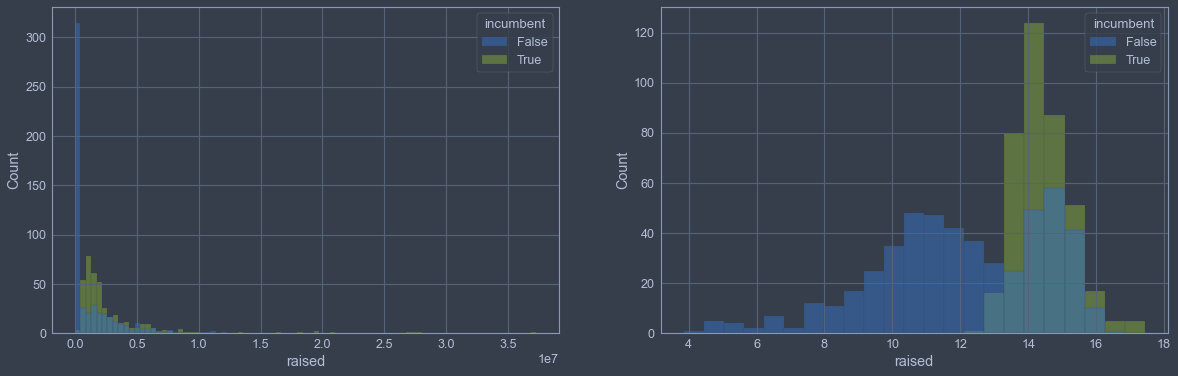

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20, 6))

sns.histplot(x = "raised", data=US, hue = 'incumbent', ax = ax1);
sns.histplot(x = np.log(US["raised"]), data=US, hue = 'incumbent', ax = ax2);

### Scatter, Log-Scatter, and Point plot

C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


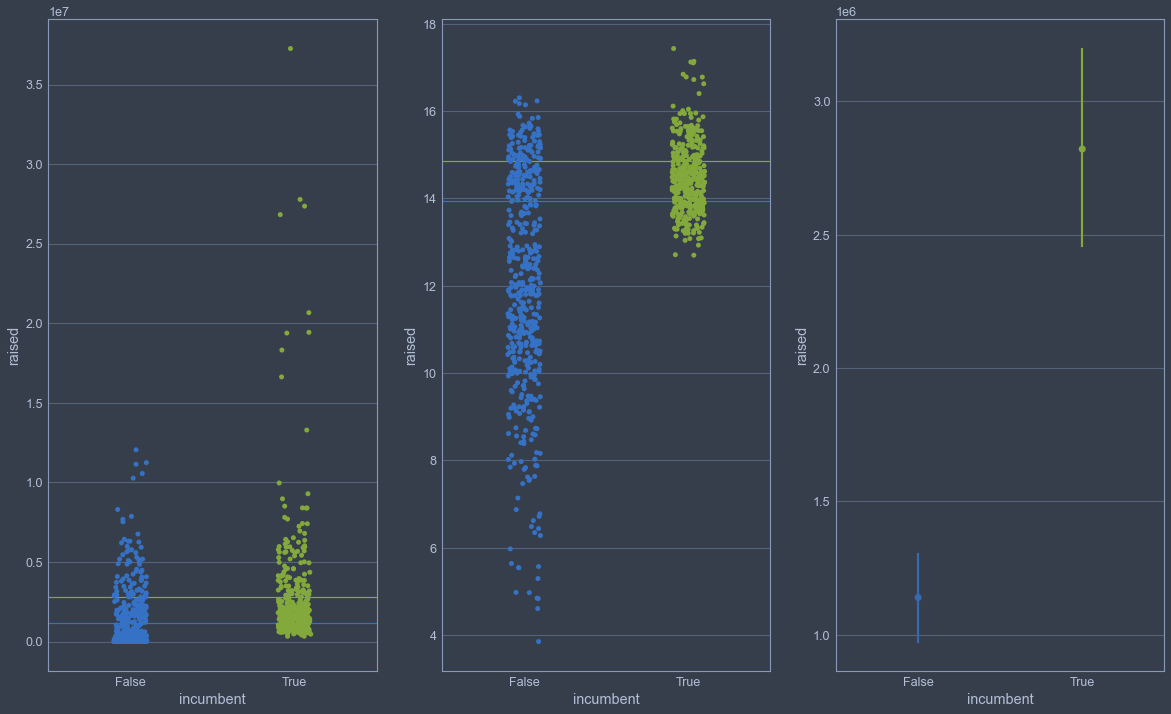

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20, 12))

sns.stripplot(x="incumbent", y="raised", data=US, ax = ax1);
ax1.axhline(US[US['incumbent'] == False]['raised'].mean())
ax1.axhline(US[US['incumbent'] == True]['raised'].mean(), color = '#83A83B')

sns.stripplot(x="incumbent", y=np.log(US["raised"]), data=US, ax = ax2);
ax2.axhline(np.log(US[US['incumbent'] == False]['raised'].mean()))
ax2.axhline(np.log(US[US['incumbent'] == True]['raised'].mean()), color = '#83A83B')

sns.pointplot(x = 'incumbent', 
              y = 'raised', 
              data = US,
              ax = ax3,
              hue_order = [False, True],
              palette = {False: '#3569B0', True:'#83A83B'}
             );

### Linear Models: Base Constant and Raised vs Incumbent

Here we construct a base model for comparative reference.

In [16]:
lin_reg_base = (sm.GLM(endog = US['raised'],
                       exog = sm.add_constant(US[[]]),
                       family = sm.families.Gaussian()
                      )
                .fit()
               )

print(lin_reg_base.summary(), '\n', 'Base AIC: '+str(lin_reg_base.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 raised   No. Observations:                  894
Model:                            GLM   Df Residuals:                      893
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                      9.1565e+12
Method:                          IRLS   Log-Likelihood:                -14609.
Date:                Fri, 22 Oct 2021   Deviance:                   8.1767e+15
Time:                        22:04:21   Pearson chi2:                 8.18e+15
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.866e+06   1.01e+05     18.434      0.0

Here we construct the linear regression model. Note that the AIC is better (lower) than the base model's, if only slightly. You can't really make a good prediction of value from this model, but, based on earlier results, you can expect the incumbent to raise more money than the challenger.

In [17]:
lin_reg_incumb = (sm.GLM(endog = US['raised'],
                       exog = sm.add_constant(US['incumbent'].astype('int')),
                       family = sm.families.Gaussian()
                      )
                .fit()
               )

print(lin_reg_incumb.summary(), '\n', 'Incumbent AIC: '+str(lin_reg_incumb.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 raised   No. Observations:                  894
Model:                            GLM   Df Residuals:                      892
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      8.4710e+12
Method:                          IRLS   Log-Likelihood:                -14574.
Date:                Fri, 22 Oct 2021   Deviance:                   7.5561e+15
Time:                        22:04:21   Pearson chi2:                 7.56e+15
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.139e+06   1.29e+05      8.823      0.0

# Sources of Funding

In [18]:
TOC = SOF.groupby('type of contribution', as_index = False)['amount'].sum()
TOC['proportion'] = TOC['amount']/TOC['amount'].sum()
TOC_party = SOF.groupby(['type of contribution', 'party'], as_index = False)['amount'].sum()

## What the overall distribution of funding sources look like?

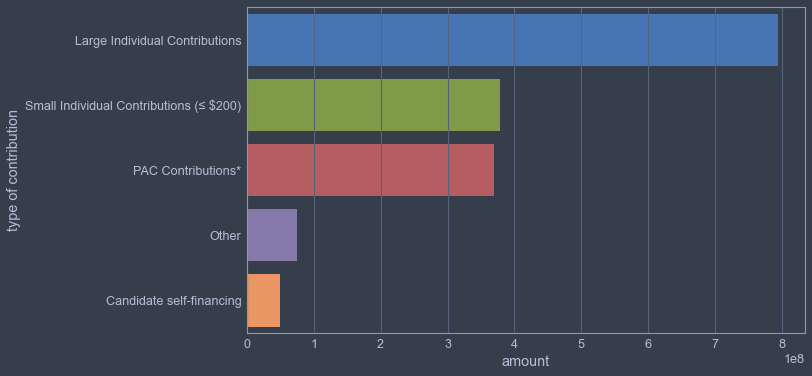

,type of contribution,amount,proportion
1,Large Individual Contributions,794772493,0.476499
4,Small Individual Contributions (≤ $200),377748710,0.226476
3,PAC Contributions*,370225791,0.221966
2,Other,75481464,0.045254
0,Candidate self-financing,49711634,0.029804


In [25]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(y = 'type of contribution', 
            x = 'amount', 
            data = TOC,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax
           )
plt.show()

display(TOC.sort_values('amount', ascending = False))

## Is there any detectable difference in contribution sources between Democrat and Republican?

In [31]:
TOC_DR = TOC_party[TOC_party['party'].isin(['D','R'])].copy()
TOC_DR['party proportion amount'] = TOC_DR['amount']/TOC_DR.groupby('party')['amount'].transform('sum')

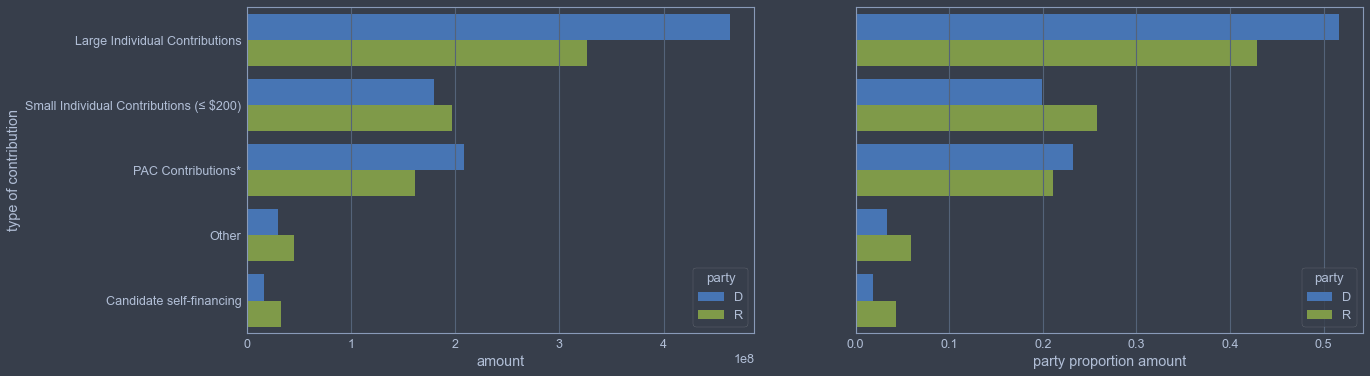

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
sns.barplot(y = 'type of contribution', 
            x = 'amount', 
            hue = 'party', 
            data = TOC_DR,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax1
           );
sns.barplot(y = 'type of contribution', 
            x = 'party proportion amount', 
            hue = 'party', 
            data = TOC_DR,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax2
           );
ax2.set(ylabel = None, yticks = [])
plt.show()

## Do the funding sources from the winning candidate or incumbent candidate differ from the other candidates?

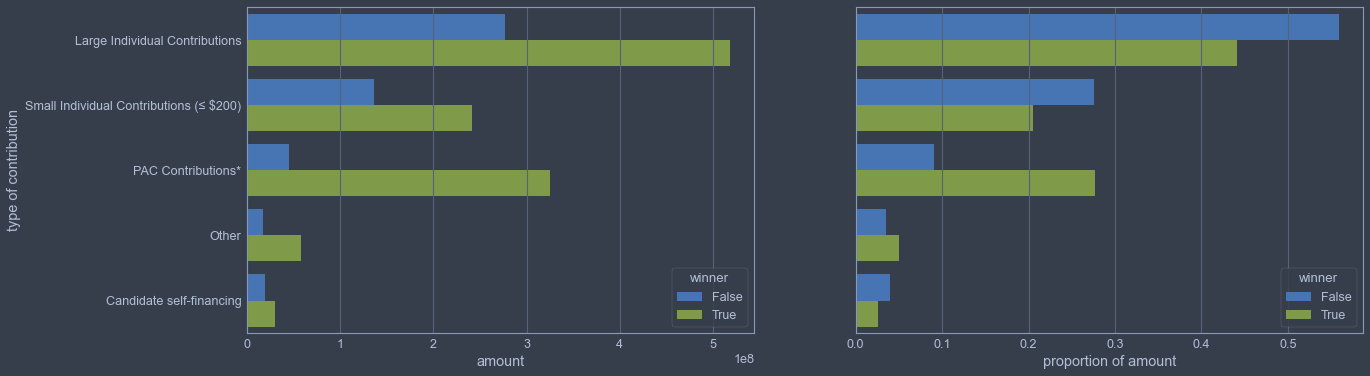

In [47]:
TOC_winner = SOF.groupby(['type of contribution', 'winner'], as_index = False)['amount'].sum()
TOC_winner['proportion of amount'] = TOC_winner['amount']/TOC_winner.groupby('winner')['amount'].transform('sum')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
sns.barplot(y = 'type of contribution', 
            x = 'amount', 
            hue = 'winner', 
            data = TOC_winner,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax1
           );
sns.barplot(y = 'type of contribution', 
            x = 'proportion of amount', 
            hue = 'winner', 
            data = TOC_winner,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax2
           );
ax2.set(ylabel = None, yticks = [])
plt.show()

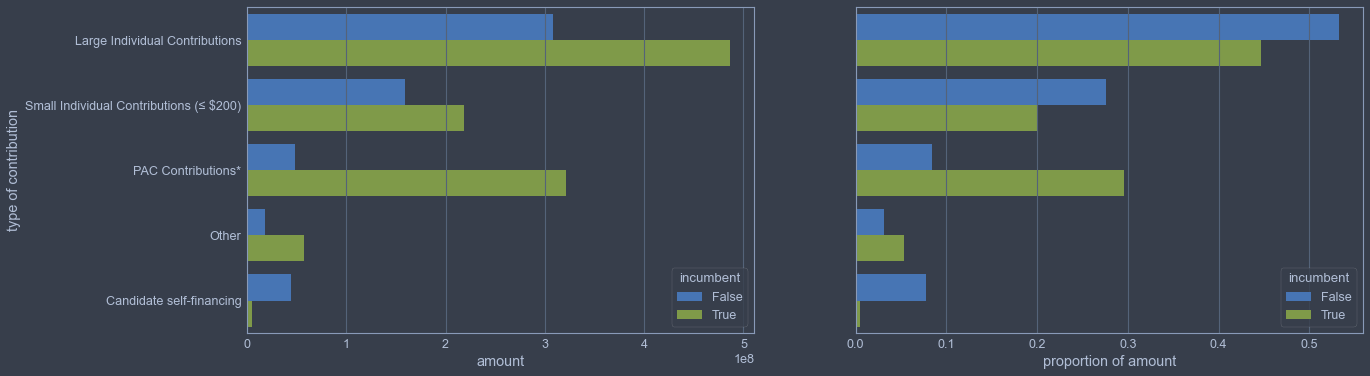

In [49]:
TOC_incumbent = SOF.groupby(['type of contribution', 'incumbent'], as_index = False)['amount'].sum()
TOC_incumbent['proportion of amount'] = TOC_incumbent['amount']/TOC_incumbent.groupby('incumbent')['amount'].transform('sum')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
sns.barplot(y = 'type of contribution', 
            x = 'amount', 
            hue = 'incumbent', 
            data = TOC_incumbent,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax1
           );
sns.barplot(y = 'type of contribution', 
            x = 'proportion of amount', 
            hue = 'incumbent', 
            data = TOC_incumbent,
            orient = 'h',
            order = TOC.sort_values('amount', ascending = False)['type of contribution'],
            ax = ax2
           );
ax2.set(ylabel = None, yticks = [])
plt.show()